In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.externals.joblib import dump
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_data_1=pd.read_csv('/content/drive/MyDrive/Airbnb trail/overall_preprocessed_train.csv')
cv_data=pd.read_csv('/content/drive/MyDrive/Airbnb trail/overall_preprocessed_cv.csv')
test_data=pd.read_csv('/content/drive/MyDrive/Airbnb trail/overall_preprocessed_test.csv')

In [ ]:
#Droping index column
train_data_1.drop(['Unnamed: 0'],axis=1,inplace=True)
cv_data.drop(['Unnamed: 0'],axis=1,inplace=True)
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
print(train_data_1.shape)
print(cv_data.shape)
print(test_data.shape)

(62742, 760)
(11073, 760)
(62096, 759)


In [ ]:
X_train=train_data_1.drop(['id','country_destination'],axis=1)
y_train=train_data_1['country_destination']

X_cv=cv_data.drop(['id','country_destination'],axis=1)
y_cv=cv_data['country_destination']

X_test=test_data.drop(['id'],axis=1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_cv.shape)
print(y_cv.shape)
print(X_test.shape)

(62742, 758)
(62742,)
(11073, 758)
(11073,)
(62096, 758)


**Encoding Labels**

In [ ]:
le=LabelEncoder()
le.fit(y_train)

y_train=le.transform(y_train)
y_cv=le.transform(y_cv)

In [ ]:
le.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [ ]:
dump(le,'/content/drive/MyDrive/Airbnb trail/class_label_encoder.bin',compress=True)

['/content/drive/MyDrive/Airbnb trail/class_label_encoder.bin']

In [ ]:
from sklearn.externals.joblib import load
le=load('/content/drive/MyDrive/Airbnb trail/class_label_encoder.bin')

y_train=le.transform(y_train)
y_cv=le.transform(y_cv)

**NDCG Score**

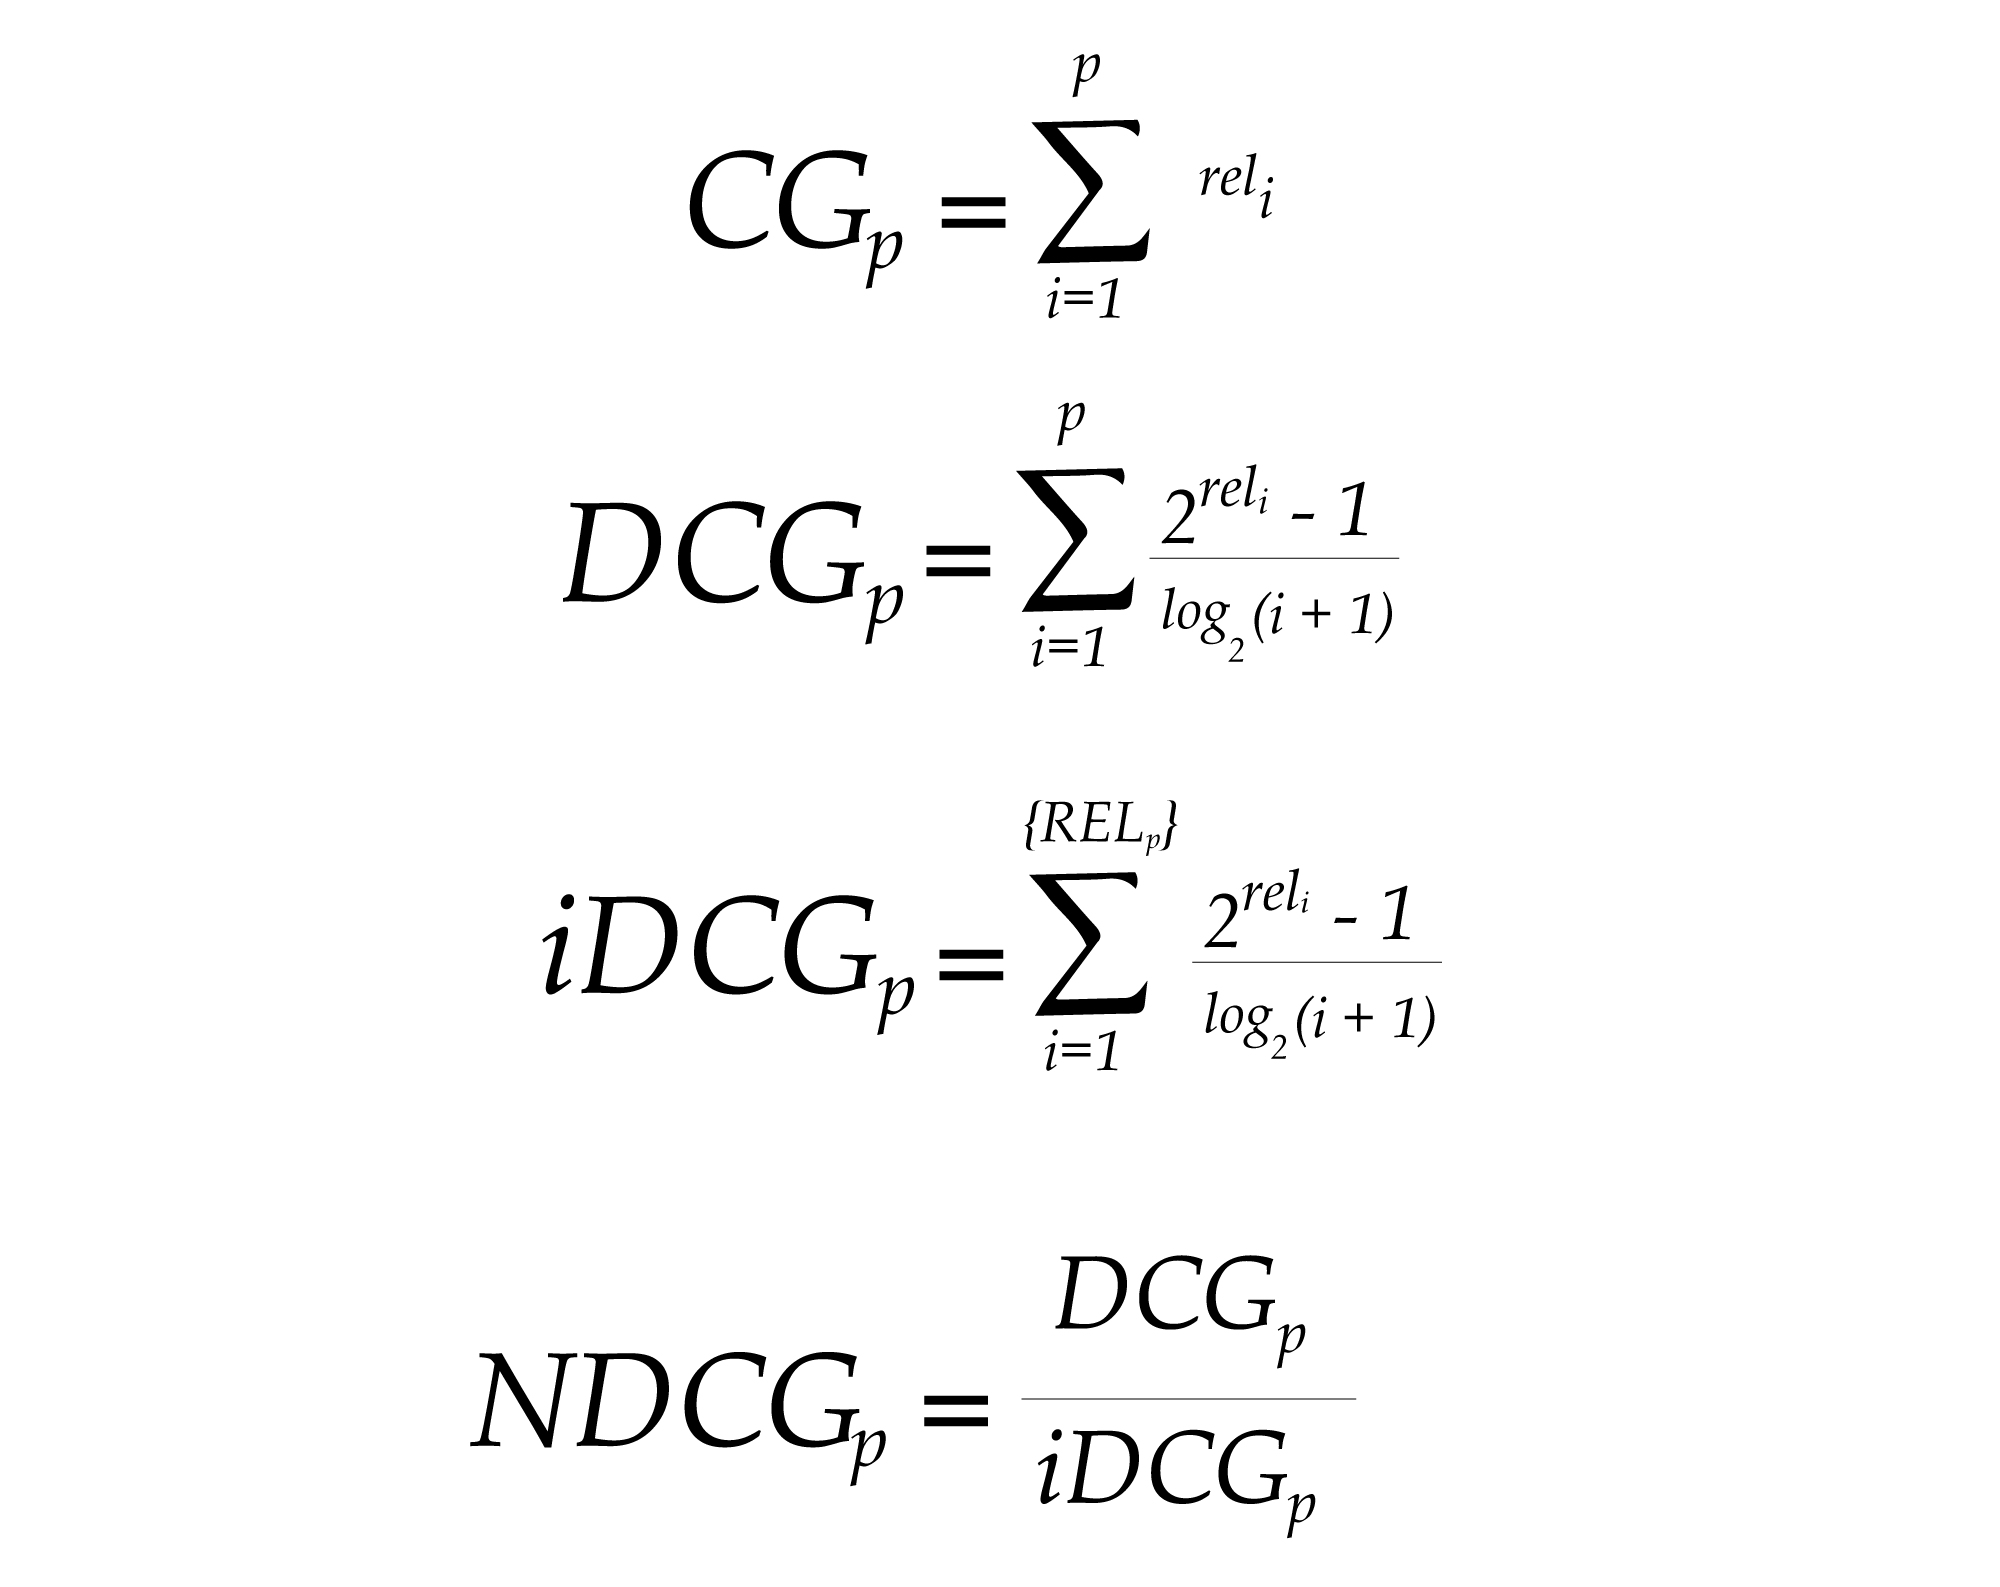

Reference:

https://www.searchunify.com/blog/the-whys-and-hows-of-measuring-search-relevance/

In [ ]:
#https://www.kaggle.com/davidgasquez/ndcg-scorer

from sklearn.metrics import make_scorer
def dcg_score(y_true, y_score, k=5):
    """
    Discounted Cummulative Gain(dcg)= sum(i:1 to k) ((2**relavance(i))-1)/(log2(i+1))
    Here y_true is array which is label encoded and y_score is the probability score
    eg:
      y_true=[0,0,0,1,0,0,0,0,0,0,0,0] (For destination ES)
      y_score=[0,0,0,0.70,0,0.025,0,0.15,0,0,0.1,0.025]
    we argsort in highest order of y_score
    order=[3,6,9,5,12,......]
    now we take the top 5 index of the order and pick values of those top 5 index from y_true.
    gain=[(2**1)-1,(2**0)-1,(2**0)-1,...]
    discount=[log2(1+1),log2(2+1),log2(3+1),...]
    dcg=sum(gain/discount)

    parameter:
      y_true : numpy array of shape [n_samples,number_of_classes]
      y_score: numpy array of shape [n_samples,number_of_classes]
      k      : int (default=5)
    
    returns:
      dcg    : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
  
def ndcg_score(ground_truth, predictions, k=5):
    """
    Normalized Discounted Cummulative Gain (ndcg)= Discounted Cummulative Gain/Ideal Discounted Cummulative Gain
    idcg=sum(i: 1 to k)((2**true_relavance(i))-1)/(log2(i+1))
    In idcg the probability score (ie y_score) will be y_true

    parameter:
      ground_truth: numpy array of shape [n_samples,]
      predictions : numpy array of shape [n_samples,number_of_classes]
      k           : int (default=5)

    returns:
      score       : float
      (average ndcg score) 
    """
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        if best == 0:
            best = 0.000000001
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


In [ ]:
import random
def generate_index(params,previous_indices):
  """
  generates a list of integers which are the indices of the parameter given
  
  parameter:
        params            : list (list of parameters that are to be tested)
        previous_indices  : list (list of previous indices)

  returns:
        indices_list      : list (list of indices for each parameter)
  """
  indices_list=[]
  for i in params:
    ind=np.random.randint(0,len(i))#generates a number between 0 and number of values defined for a particular parameter
    indices_list.append(ind)
  if indices_list in previous_indices:# If the same set of indices have already been executed then another set of indices will be generated
    indices_list=generate_index(params,previous_indices)
  return indices_list

##Decision Trees##

In [ ]:
max_depth=[2,5,10,20,50]
for depth in max_depth:
  dt=DecisionTreeClassifier(max_depth=depth)
  dt.fit(X_train,y_train)
  dt_train_prediction=dt.predict_proba(X_train)
  dt_test_prediction=dt.predict_proba(X_cv)
  dt_train_ndcg_score=ndcg_score(y_train,dt_train_prediction,k=5)
  dt_test_ndcg_score=ndcg_score(y_cv,dt_test_prediction,k=5)
  print("Depth of tree: ",depth)
  print("Train NDCG score of Decision tree: ",dt_train_ndcg_score)
  print("Test NDCG score of Decision tree: ",dt_test_ndcg_score)

Depth of tree:  2
Train NDCG score of Decision tree:  0.8430171719522203
Test NDCG score of Decision tree:  0.8424324893237124
Depth of tree:  5
Train NDCG score of Decision tree:  0.8521446791393282
Test NDCG score of Decision tree:  0.8516381739378435
Depth of tree:  10
Train NDCG score of Decision tree:  0.865490422251681
Test NDCG score of Decision tree:  0.845931748194873
Depth of tree:  20
Train NDCG score of Decision tree:  0.9216900156308674
Test NDCG score of Decision tree:  0.8080323563893432
Depth of tree:  50
Train NDCG score of Decision tree:  0.9971121408407783
Test NDCG score of Decision tree:  0.7410870233685314


In [ ]:
dt=DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Feature Importance in Decision Tree**

Text(0, 0.5, 'Column_names')

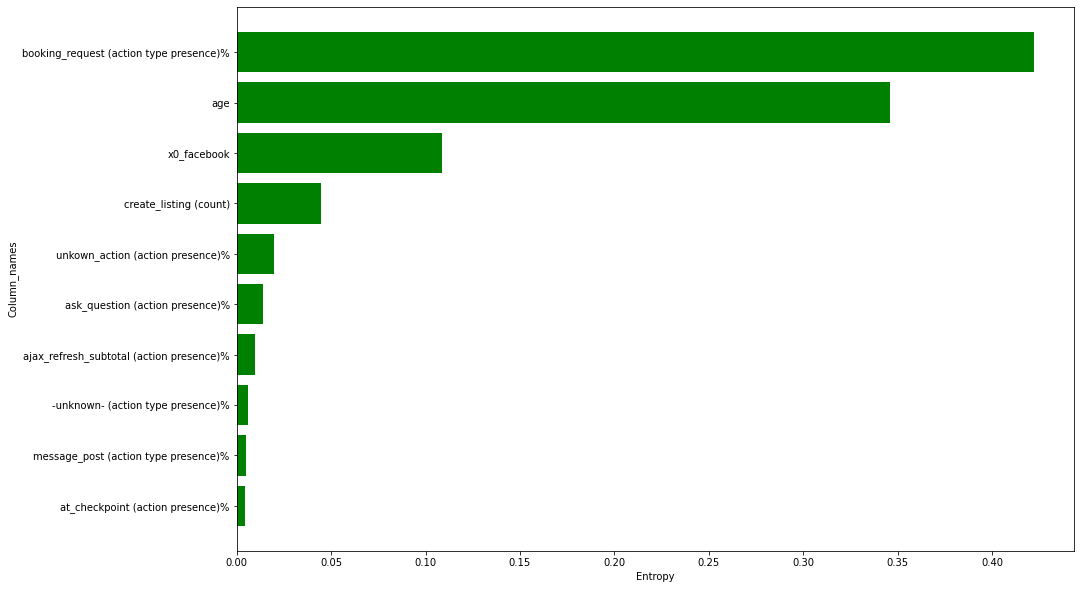

In [ ]:
columns_index=dt.feature_importances_.argsort()[::-1][:10]
values=dt.feature_importances_[columns_index][::-1]
column_names=X_train.columns[columns_index][::-1]

plt.figure(figsize=(15,10))
plt.barh(np.arange(len(column_names)),values,color='green',align='center')
plt.yticks(ticks=np.arange(len(column_names)),labels=column_names)
plt.xlabel('Entropy')
plt.ylabel('Column_names')

Here we can see that ratio of action and action type played a significant role.

#Random Forest#

In [ ]:
n_iter=15 #Number of parameter testings needed
n_estimator=[50,100,200,300]
max_depth=[100,200]
min_samples_split=[2, 3, 5, 8]
min_samples_leaf=[1, 2, 5, 10]
previous_indices=[]

for i in range(n_iter):
  indices=generate_index([n_estimator,max_depth,min_samples_split,min_samples_leaf],previous_indices)
  previous_indices.append(indices)
  forest=RandomForestClassifier(n_estimators=n_estimator[indices[0]],
                                max_depth=max_depth[indices[1]],
                                min_samples_split=min_samples_split[indices[2]],
                                min_samples_leaf=min_samples_leaf[indices[3]],
                                n_jobs=-1,bootstrap=False)
  forest.fit(X_train,y_train)
  prob_score_train=forest.predict_proba(X_train)
  prob_score_test=forest.predict_proba(X_cv)
  forest_train_ndcg_score=ndcg_score(y_train,prob_score_train,k=5)
  forest_test_ndcg_score=ndcg_score(y_cv,prob_score_test,k=5)
  print("Depth of Tree : ",max_depth[indices[1]])
  print("Estimator : ",n_estimator[indices[0]])
  print("Min samples split : ",min_samples_split[indices[2]])
  print("Min samples leaf : ",min_samples_leaf[indices[3]])
  print('NDCG score for train : ',forest_train_ndcg_score)
  print('NDCG score for test:',forest_test_ndcg_score)
  print("*************************")

Depth of Tree :  100
Estimator :  100
Min samples split :  8
Min samples leaf :  5
NDCG score for train :  0.934336833659979
NDCG score for test: 0.8544243453219369
*************************
Depth of Tree :  200
Estimator :  100
Min samples split :  3
Min samples leaf :  5
NDCG score for train :  0.9348142445074692
NDCG score for test: 0.8538282394303203
*************************
Depth of Tree :  100
Estimator :  300
Min samples split :  2
Min samples leaf :  1
NDCG score for train :  0.9999647059150398
NDCG score for test: 0.8503746472633018
*************************
Depth of Tree :  200
Estimator :  200
Min samples split :  3
Min samples leaf :  1
NDCG score for train :  0.9999647059150398
NDCG score for test: 0.8513742102290992
*************************
Depth of Tree :  100
Estimator :  300
Min samples split :  2
Min samples leaf :  10
NDCG score for train :  0.909156796035337
NDCG score for test: 0.8550287490237078
*************************
Depth of Tree :  100
Estimator :  50
Min 

The best estimators are {'max_depth'=100,'n_estimators'=300,'min_samples_split'=5,'min_samples_leaf'=10} which gave a test score of 0.85548 and train score of 0.90915. We can see that the model is overfitting.

In [ ]:
X_train_combined=np.r_[X_train,X_cv]
y_train_combined=np.r_[y_train,y_cv]

forest=RandomForestClassifier(max_depth=100,n_estimators=300,
                              min_samples_split=5,min_samples_leaf=10,
                              n_jobs=-1,bootstrap=False)
forest.fit(X_train_combined,y_train_combined)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Let us check the feature importance.

Text(0, 0.5, 'Column_names')

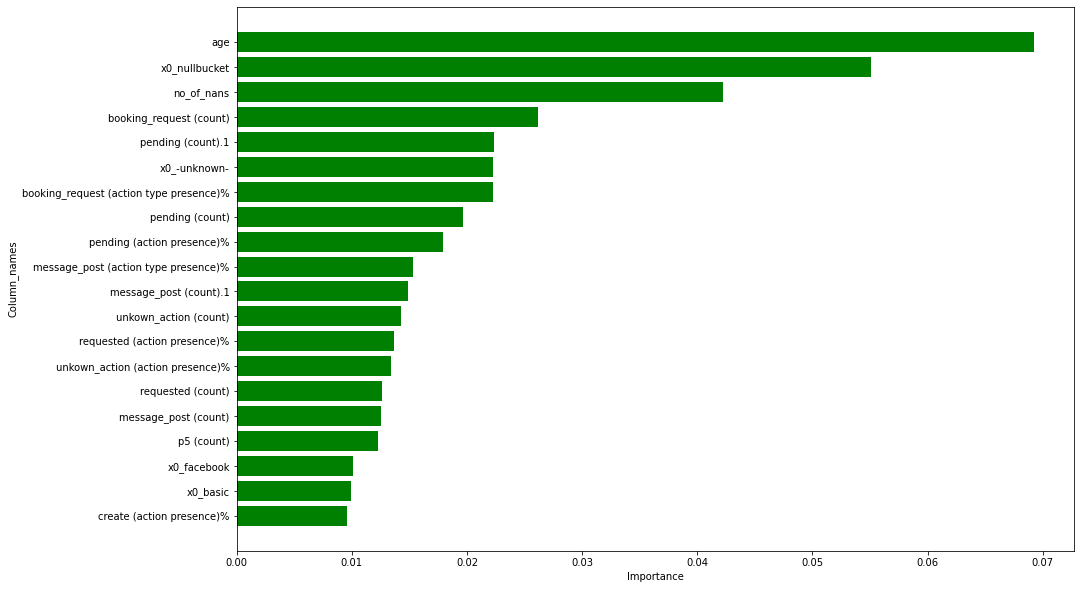

In [ ]:
columns_index=forest.feature_importances_.argsort()[::-1][:20]
values=forest.feature_importances_[columns_index][::-1]
column_names=X_train.columns[columns_index][::-1]

plt.figure(figsize=(15,10))
plt.barh(np.arange(len(column_names)),values,color='green',align='center',)
plt.yticks(ticks=np.arange(len(column_names)),labels=column_names)
plt.xlabel('Importance')
plt.ylabel('Column_names')

We can see that 'age','null bucket','non_of_nans' contributed a lot for the prediction. This shows that how the null values impacted for prediction. As we treated null values differently ( i.e without filling it with median value) we can best differentiate users prediction. The above bar diagram show the importance of nans in the dataset. We can also see that a lot of ratio values also helped in prediction. 

In [ ]:
train_proba=forest.predict_proba(X_train_combined)
score=ndcg_score(y_train_combined,train_proba,k=5)
print('train score:',score)

train score: 0.9094379863154995


In [ ]:
test_data_proba=forest.predict_proba(np.array(X_test))
test_ids=test_data['id']
ids=[]
countries=[]
test_prediction_sorted=np.argsort(test_data_proba,axis=1)
for id in range(len(test_ids)):
  idx=test_ids.iloc[id]
  ids+=[idx]*5
  countries+=le.inverse_transform(test_prediction_sorted[id][::-1][:5]).tolist()
final_prediction=pd.DataFrame(np.column_stack((ids,countries)),columns=['id','country'])
final_prediction.to_csv('random_forest_final_pred.csv',index=False)

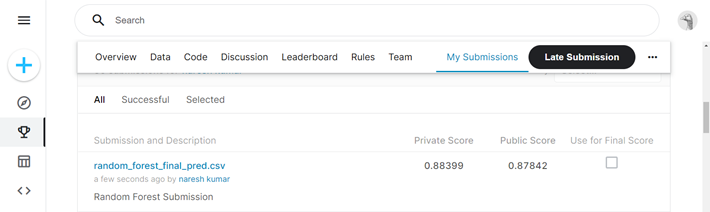

The test submission gave a private LB score of 0.88399 and public LB score of 0.87842. This makes top 13% in the private LB and top 16% in public LB.

#XGB#

In [ ]:
n_iter=20
n_estimator= [100,200] 
max_depth= [4,5,6]
learning_rate=[0.001, 0.01, 0.1, 0.2]
subsample=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_child_weight=[0.25,0.5, 1.0, 3.0, 5.0, 7.0]
gamma=[0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0]
reg_lambda=[0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0]
colsample_bytree=[0.1,0.3,0.5,1]
colsample_bylevel=[0.1,0.3,0.5,1]
previous_indices=[]

for i in range(n_iter):
  indices=generate_index([n_estimator,max_depth,learning_rate,subsample,min_child_weight,
                          gamma,reg_lambda,colsample_bytree,colsample_bylevel],previous_indices)
  previous_indices.append(indices)
  xgb=XGBClassifier(n_estimators=n_estimator[indices[0]],max_depth=max_depth[indices[1]],
                    learning_rate=learning_rate[indices[2]],subsample=subsample[indices[3]],
                    min_child_weight=min_child_weight[indices[4]],gamma=gamma[indices[5]],
                    reg_lambda=reg_lambda[indices[6]],colsample_bytree=colsample_bytree[indices[7]],
                    colsample_bylevel=colsample_bylevel[indices[8]],n_jobs=-1,
                    objective='multi:softmax',eval='mlogloss',verbose=10)
  xgb.fit(X_train,y_train)
  prob_score_train=xgb.predict_proba(X_train)
  prob_score_test=xgb.predict_proba(X_cv)
  xgb_score_train=ndcg_score(y_train,prob_score_train,k=5)
  xgb_score_test=ndcg_score(y_cv,prob_score_test,k=5)
  print("Depth of Tree : ",max_depth[indices[1]])
  print("Estimator : ",n_estimator[indices[0]])
  print("Learning rate : ",learning_rate[indices[2]])
  print("Subsample : ",subsample[indices[3]])
  print("Min child weight : ",min_child_weight[indices[4]])
  print("Gamma : ",gamma[indices[5]])
  print("Reg lambda : ",reg_lambda[indices[6]])
  print("Column sample by tree : ",colsample_bytree[indices[7]])
  print("Column sample by level : ",colsample_bylevel[indices[8]])
  print('NDCG score for train : ',xgb_score_train)
  print('NDCG score for train : ',xgb_score_test)
  print("*************************")

Depth of Tree :  6
Estimator :  200
Learning rate :  0.001
Subsample :  0.8
Min child weight :  0.5
Gamma :  0
Reg lambda :  0.1
Column sample by tree :  0.3
Column sample by level :  0.3
NDCG score for train :  0.855101707769371
NDCG score for train :  0.848152487614895
*************************
Depth of Tree :  4
Estimator :  100
Learning rate :  0.1
Subsample :  0.8
Min child weight :  0.5
Gamma :  1.0
Reg lambda :  0.2
Column sample by tree :  0.3
Column sample by level :  0.1
NDCG score for train :  0.8617835147656693
NDCG score for train :  0.8531753649826949
*************************
Depth of Tree :  4
Estimator :  200
Learning rate :  0.001
Subsample :  0.7
Min child weight :  1.0
Gamma :  0.5
Reg lambda :  0.2
Column sample by tree :  0.1
Column sample by level :  1
NDCG score for train :  0.8470704469484818
NDCG score for train :  0.8444652416157745
*************************
Depth of Tree :  6
Estimator :  100
Learning rate :  0.01
Subsample :  0.9
Min child weight :  1.0
Gam

The best estimators are {'max_depth'=6,'n_estimators'=100, 'learning_rate'=0.1,'subsample'=0.5,'min_child_weight'=5,'gamma'=1.0,'reg_lambda'=0.8,'colsample_bytree'=0.3,'colsample_bylevel'=1} which gave a test score of 0.87487 and train score of 0.85717.

In [ ]:
X_train_combined=np.r_[X_train,X_cv]
y_train_combined=np.r_[y_train,y_cv]

xgboost=XGBClassifier(max_depth=6,n_estimators=100,learning_rate=0.1,
                      subsample=0.5,min_child_weight=5.0,gamma=1.0,
                      reg_lambda=0.8,colsample_bytree=0.3,colsample_bylevel=1,
                      n_jobs=-1,objective='multi:softmax',eval='mlogloss')
xgboost.fit(X_train_combined,y_train_combined)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval='mlogloss',
              gamma=1.0, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5.0, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [ ]:
xgboost.save_model('/content/drive/MyDrive/Airbnb test/xgb.json')

Text(0, 0.5, 'Column_names')

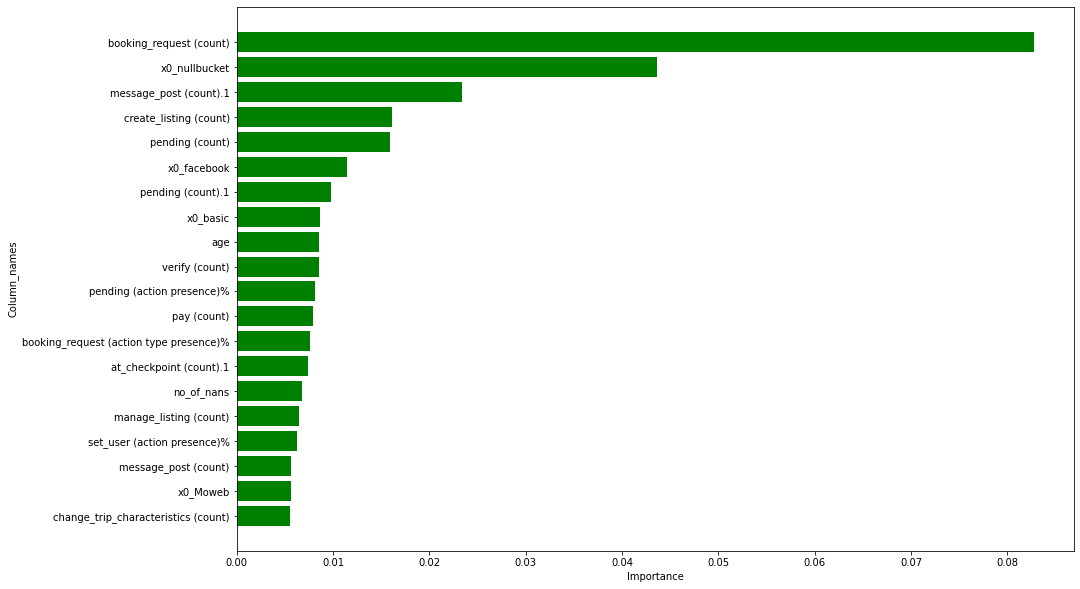

In [ ]:
columns_index=xgboost.feature_importances_.argsort()[::-1][:20]
values=xgboost.feature_importances_[columns_index][::-1]
column_names=X_train.columns[columns_index][::-1]

plt.figure(figsize=(15,10))
plt.barh(np.arange(len(column_names)),values,color='green',align='center',)
plt.yticks(ticks=np.arange(len(column_names)),labels=column_names)
plt.xlabel('Importance')
plt.ylabel('Column_names')

Here booking_request(count) gained a lot of attraction for predition. The most popular are the counts of the action(ie unigram of action feature) which played a significant role in predction while there are some ratio of ation features and some users dataset feature(null_bucket, facebook, basic, age and no_of_nans) gave some contribution. 

In [ ]:
train_combined_proba=xgboost.predict_proba(X_train_combined)
train_score=ndcg_score(y_train_combined,train_combined_proba)
print('train score:',train_score)

train score: 0.8733024903309071


In [ ]:
# https://www.kaggle.com/kevinwu06/feature-importance-w-xgboost
test_data_proba=xgboost.predict_proba(np.array(X_test))
test_ids=test_data['id']
ids=[]
countries=[]
test_prediction_sorted=np.argsort(test_data_proba,axis=1)
for id in range(len(test_ids)):
  idx=test_ids.iloc[id]
  ids+=[idx]*5
  countries+=le.inverse_transform(test_prediction_sorted[id][::-1][:5]).tolist()
final_prediction=pd.DataFrame(np.column_stack((ids,countries)),columns=['id','country'])
final_prediction.to_csv('xgboost_final_pred.csv',index=False)

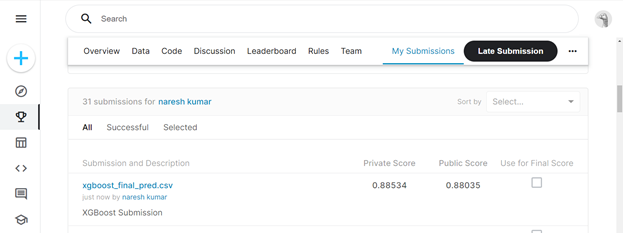

XGBoost gave us test score of 0.88534 in private LB and 0.88035 in public LB. This makes in top 8% in private LB and top 9% in public LB.

This model has done the best.

In [ ]:
#Saving model
dump(xgboost,'/content/drive/MyDrive/Airbnb trail/xgboost_model.bin',compress=True)

['/content/drive/MyDrive/Airbnb trail/xgboost_model.bin']

Reference for hyper parameter definitions: 

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

Hyper parameter tuning reference:

https://medium.com/swlh/airbnb-new-user-bookings-kaggle-competition-9925ef41b623

#Table#

In [ ]:
from prettytable import PrettyTable
table=PrettyTable()
table.field_names=['Model','Train Score','Test Score','Kaggle Score private LB','Kaggle score public LB']
table.add_row(['Decision Tree',0.85214,0.85163,'-','-'])
table.add_row(['Random Forest',0.90915,0.85558,0.88399,0.87842])
table.add_row(['XGBoost',0.87487,0.85717,0.88534,0.88035])

In [ ]:
print(table)

+---------------+-------------+------------+-------------------------+------------------------+
|     Model     | Train Score | Test Score | Kaggle Score private LB | Kaggle score public LB |
+---------------+-------------+------------+-------------------------+------------------------+
| Decision Tree |   0.85214   |  0.85163   |            -            |           -            |
| Random Forest |   0.90915   |  0.85558   |         0.88399         |        0.87842         |
|    XGBoost    |   0.87487   |  0.85717   |         0.88534         |        0.88035         |
+---------------+-------------+------------+-------------------------+------------------------+


From the above table we can see that XGBoost did the best making up in top 8% in the private leader board in kaggle.